In [3]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import numpy as np
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import plot_tree
import joblib

In [4]:
df = pd.read_csv(r'C:\Users\Élio Vieira\Desktop\IronHack\final_project\data\raw data\data_leadzai_ironhack.csv')
df_original = pd.read_csv(r'C:\Users\Élio Vieira\Desktop\IronHack\final_project\data\raw data\data_leadzai_ironhack.csv')

In [5]:
df

,campaign_id,vertical,partner_name,internal_state_id,goal_id,state_id,advertiser_country,created_date,schedule_start,schedule_end,max_goals,cost_per_goal,input_amount,advertising_platform_id
0,1,Interior Design & Furniture,Partner C,no_funds,clicks,enabled,BE,"Feb 17, 2022, 9:24:34 AM","Mar 7, 2022",NaN,4752.0,0.11,522.7200,NaN
1,2,Cars & Motorbikes,Partner C,enabled,clicks,enabled,BE,"Jun 7, 2022, 9:46:55 AM","Jun 7, 2022",NaN,4720.0,0.19,896.8000,NaN
2,3,Health,Partner B,enabled,clicks,paused,ES,"Sep 1, 2021, 6:37:09 PM","Sep 15, 2020","Dec 14, 2021",4375.0,0.02,87.5000,NaN
3,4,Agriculture,Partner B,enabled,clicks,paused,ES,"Sep 1, 2021, 3:25:41 PM","Jul 17, 2020","Nov 9, 2021",4184.0,0.02,83.6800,NaN
4,5,Health,Partner B,enabled,clicks,paused,ES,"Sep 1, 2021, 6:27:55 PM","Sep 15, 2020","Nov 14, 2021",3116.0,0.02,62.3200,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22362,22363,Finance,Partner C,no_funds,clicks,enabled,BE,"Feb 9, 2022, 12:44:05 PM","Feb 9, 2022",NaN,NaN,NaN,NaN,NaN
22363,22364,Finance,Partner C,no_funds,clicks,enabled,BE,"Feb 9, 2022, 12:40:30 PM","Feb 9, 2022",NaN,NaN,NaN,NaN,NaN
22364,22365,Home Improvement & Maintenance,Partner C,no_funds,clicks,enabled,BE,"Mar 17, 2022, 1:53:56 PM","Mar 17, 2022",NaN,NaN,0.33,100.0000,NaN
22365,22366,Home Improvement & Maintenance,Partner C,no_funds,clicks,enabled,BE,"Jun 21, 2021, 8:07:48 AM","Jun 21, 2021",NaN,NaN,0.76,679.4400,NaN


## Data Cleaning

##### Summary

1. I first checked the amount of NaN values per column.

2. The max_goals column contains 9207 NaN values out of 11287, in which case dropping the NaN values would impair the analysis. So we conclude that max_goals is equal to imout_amount divided by cost_per_goal and we calculate the values to replace the NaN values.

3. I noticed that there was also a lot of NaN in the ads_aggregate_state column, so I dropped it because I can use only the state_id column.

In [6]:
df['max_goals'] = df['input_amount'] / df['cost_per_goal']

df['max_goals'].fillna(df['max_goals'], inplace=True)

In [7]:
df.drop(columns=['created_date'], inplace=True)

In [8]:
df.dropna(subset=['advertising_platform_id'], inplace=True)

In [9]:
df['schedule_end'].fillna('On Going', inplace=True)

In [10]:
df['start_year'] = pd.to_datetime(df['schedule_start'], format="%b %d, %Y").dt.year

In [11]:
df.isna().sum()

campaign_id                0
vertical                   0
partner_name               0
internal_state_id          0
goal_id                    0
state_id                   0
advertiser_country         0
schedule_start             0
schedule_end               0
max_goals                  0
cost_per_goal              0
input_amount               0
advertising_platform_id    0
start_year                 0
dtype: int64

## Data Formatting

In [12]:
columns_to_round = ['cost_per_goal', 'input_amount']
df[columns_to_round] = df[columns_to_round].round(2)

In [13]:
df['max_goals'] = df['max_goals'].astype(int).astype(str)

In [14]:
df['vertical'].value_counts().head(30)

vertical
Home Improvement & Maintenance    3542
Others                            1776
Health                            1717
Industrial                        1512
Cars & Motorbikes                  831
Business                           777
Electronics                        434
Transport & Logistics              427
Food & Drinks                      424
Legal & Law                        372
Funeral Services                   330
Beauty                             313
Interior Design & Furniture        313
Restaurant                         309
Environment                        303
Animals & Pets                     256
School                             234
Accommodation & Hotels             233
Real Estate                        229
Fashion & Clothing                 226
Agriculture                        223
Security                           181
Pharmacy                           144
Flowers & Plants                   109
Accounting                         101
Finance         

In [15]:
df.dtypes

campaign_id                  int64
vertical                    object
partner_name                object
internal_state_id           object
goal_id                     object
state_id                    object
advertiser_country          object
schedule_start              object
schedule_end                object
max_goals                   object
cost_per_goal              float64
input_amount               float64
advertising_platform_id     object
start_year                   int32
dtype: object

In [16]:
df['max_goals'] = df['max_goals'].astype(int)

In [17]:
df['campaign_id'] = df['campaign_id'].astype(str)

In [72]:
df_clicks.nunique()

campaign_id                16636
vertical                      70
partner_name                   3
internal_state_id              5
goal_id                        1
state_id                       3
advertiser_country            11
schedule_start              1322
schedule_end                1384
max_goals                   1111
cost_per_goal                312
input_amount                3742
advertising_platform_id        3
start_year                     8
dtype: int64

## Splitting data

In [18]:
df_clicks = df[df['goal_id'] == 'clicks']
df_webforms = df[df['goal_id'] == 'webform']

## Data Analysis

In [97]:
df['advertising_platform_id'].unique()

array(['bing', 'adwords', 'facebook'], dtype=object)

In [93]:
df

,campaign_id,vertical,partner_name,internal_state_id,goal_id,state_id,advertiser_country,schedule_start,schedule_end,max_goals,cost_per_goal,input_amount,advertising_platform_id,start_year
89,90,Hair care,Partner C,enabled,clicks,enabled,BE,"Oct 23, 2020","Feb 5, 2021",646,0.17,109.99,bing,2020
102,103,Insurances,Partner C,enabled,clicks,enabled,BE,"Oct 23, 2020","Feb 5, 2021",611,0.09,54.99,bing,2020
110,111,Agriculture,Partner C,enabled,clicks,enabled,BE,"Oct 23, 2020","Feb 5, 2021",578,0.19,109.82,bing,2020
141,142,Cars & Motorbikes,Partner C,enabled,clicks,enabled,BE,"Oct 22, 2020","Feb 5, 2021",500,0.22,110.00,bing,2020
143,144,Hair care,Partner C,enabled,clicks,enabled,BE,"Oct 23, 2020","Feb 5, 2021",500,0.11,55.00,bing,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22104,22105,Electronics,Partner A,enabled,clicks,enabled,PT,"Jun 24, 2019","Jul 14, 2024",4709,0.20,957.88,adwords,2019
22105,22106,Industrial,Partner A,enabled,webform,paused,PT,"Mar 1, 2019","Jun 28, 2023",12,36.02,449.40,adwords,2019
22108,22109,Industrial,Partner A,enabled,clicks,enabled,PT,"Mar 21, 2019","Jul 26, 2023",2411,0.19,449.10,adwords,2019
22109,22110,Home Improvement & Maintenance,Partner A,enabled,clicks,enabled,PT,"Feb 7, 2023","Oct 26, 2024",3690,0.18,664.30,bing,2023


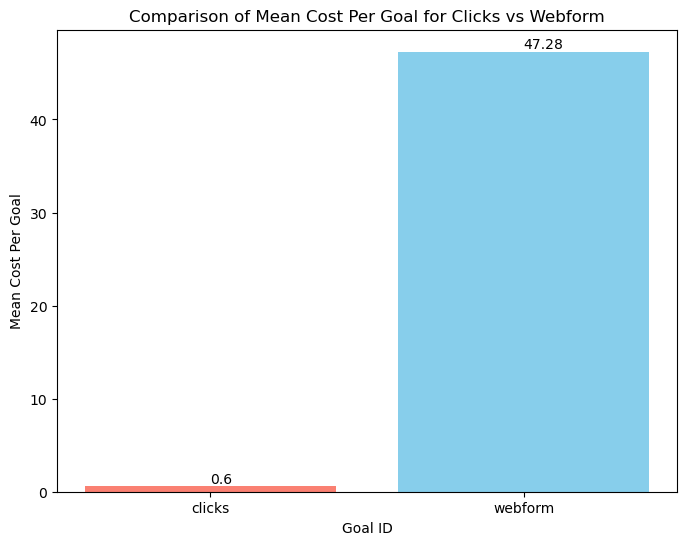

In [76]:
clicks_data = df[df['goal_id'] == 'clicks']
webform_data = df[df['goal_id'] == 'webform']

mean_clicks_cost_per_goal = clicks_data['cost_per_goal'].mean()
mean_webform_cost_per_goal = webform_data['cost_per_goal'].mean()

plt.figure(figsize=(8, 6))
bars = plt.bar(['clicks', 'webform'], [mean_clicks_cost_per_goal, mean_webform_cost_per_goal], color=['salmon', 'skyblue'])  # Customize colors

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

plt.xlabel('Goal ID')
plt.ylabel('Mean Cost Per Goal')
plt.title('Comparison of Mean Cost Per Goal for Clicks vs Webform')
plt.show()


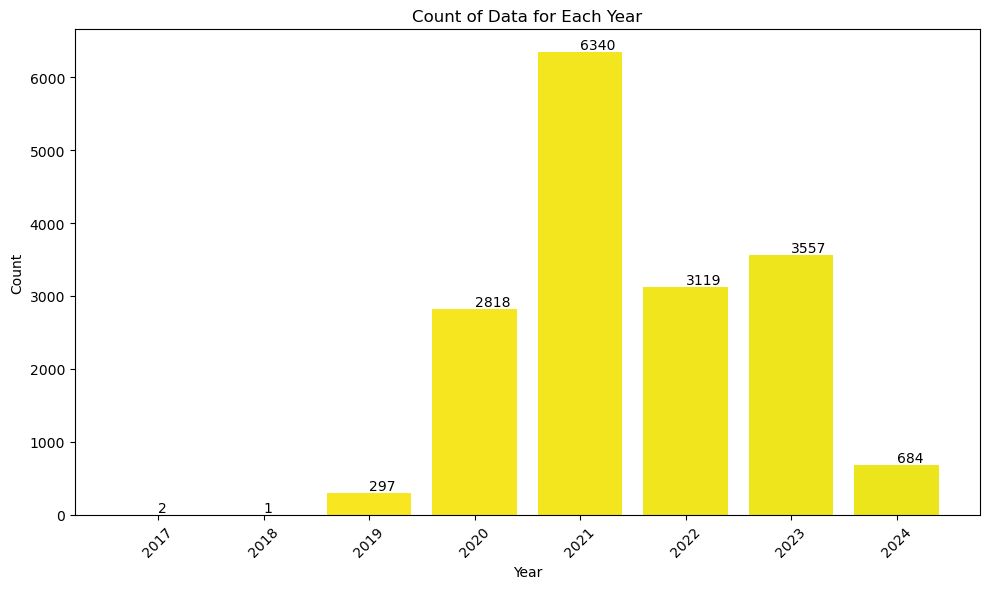

In [92]:
year_counts = df['start_year'].value_counts().sort_index()

years = [2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

year_counts = year_counts.reindex(years, fill_value=0)

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis_r(range(len(years)))  # Choose a colormap for the colors
bars = plt.bar(year_counts.index.astype(str), year_counts.values, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Data for Each Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

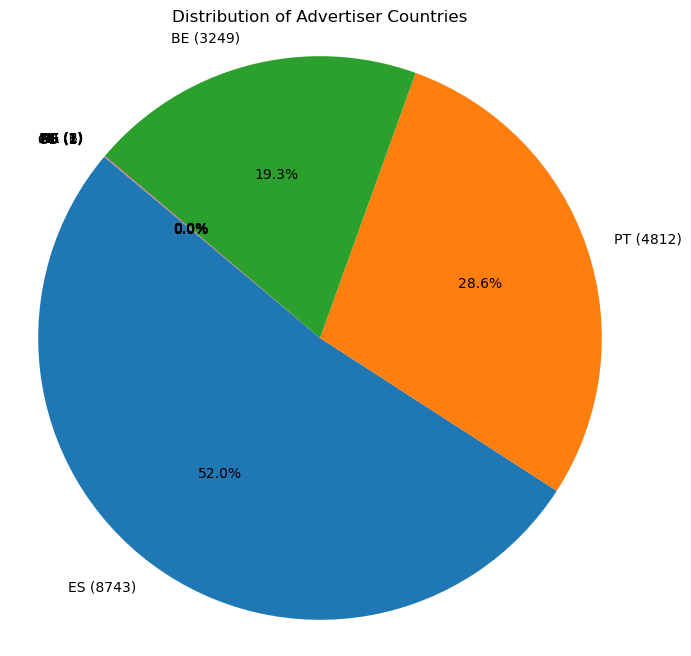

In [96]:
countries = ['BE', 'PT', 'AE', 'LU', 'NL', 'US', 'BS', 'AG', 'DE', 'GB', 'ES']
filtered_df = df[df['advertiser_country'].isin(countries)]

country_counts = filtered_df['advertiser_country'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(country_counts, labels=[f'{country} ({count})' for country, count in zip(country_counts.index, country_counts)],
        autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Advertiser Countries')
plt.axis('equal')
plt.show()

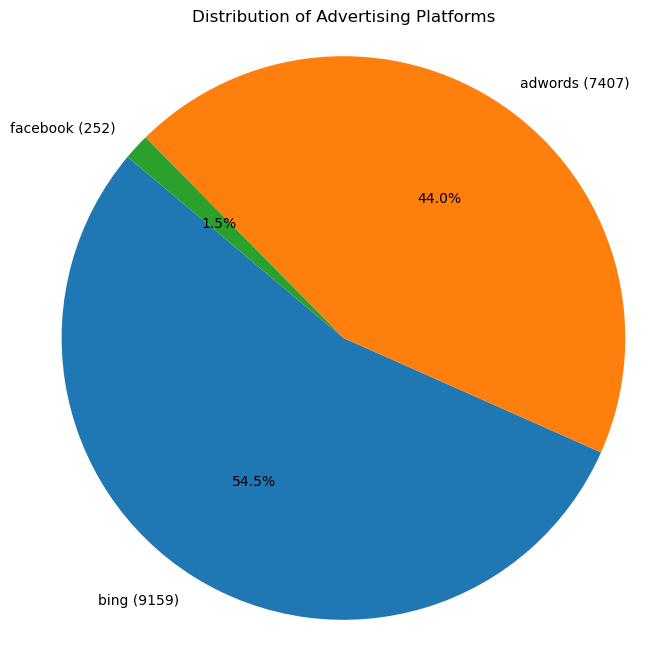

In [99]:
platforms = ['bing', 'adwords', 'facebook']
filtered_df = df[df['advertising_platform_id'].isin(platforms)]

platform_counts = filtered_df['advertising_platform_id'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(platform_counts, labels=[f'{platform} ({count})' for platform, count in zip(platform_counts.index, platform_counts)],
        autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Advertising Platforms')
plt.axis('equal')
plt.show()

In [77]:
df.describe()

,max_goals,cost_per_goal,input_amount,start_year
count,16818.000000,16818.000000,16818.000000,16818.000000
mean,218.104590,1.084408,82.872852,2021.526935
std,305.677585,17.571877,88.444137,1.166424
min,0.000000,0.010000,0.000000,2017.000000
25%,83.000000,0.290000,55.000000,2021.000000
50%,146.000000,0.470000,63.700000,2021.000000
75%,250.000000,0.720000,95.550000,2023.000000
max,11752.000000,2143.000000,7500.000000,2024.000000


In [19]:
df_describe_clicks = df_clicks.describe()
df_describe_clicks

,max_goals,cost_per_goal,input_amount,start_year
count,16636.000000,16636.000000,16636.000000,16636.000000
mean,220.095456,0.596573,81.053580,2021.527230
std,305.695573,0.506507,63.566323,1.159964
min,0.000000,0.010000,0.000000,2017.000000
25%,85.000000,0.280000,55.000000,2021.000000
50%,148.000000,0.460000,63.700000,2021.000000
75%,252.000000,0.710000,95.550000,2023.000000
max,11752.000000,5.540000,1200.000000,2024.000000


In [20]:
df_numeric_clicks = df_clicks.select_dtypes(include=['number'])
correlation_matrix = df_numeric_clicks.corr()
correlation_matrix

,max_goals,cost_per_goal,input_amount,start_year
max_goals,1.000000,-0.326197,0.536055,-0.101573
cost_per_goal,-0.326197,1.000000,0.078534,0.266224
input_amount,0.536055,0.078534,1.000000,0.107129
start_year,-0.101573,0.266224,0.107129,1.000000


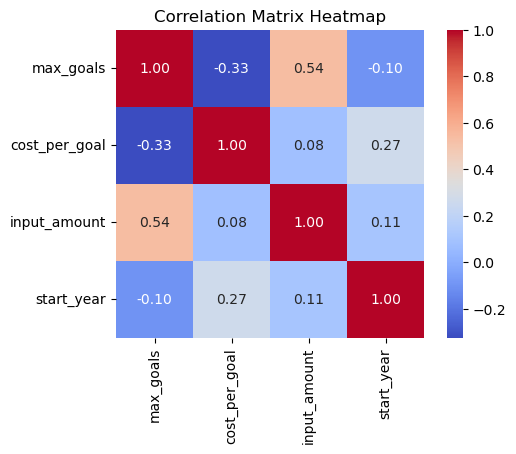

In [21]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix Heatmap')
plt.show()

ANOVA CPG vs VERTICAL

In [22]:
numerical_column_cost_per_goal_clicks = df_clicks['cost_per_goal']
categorical_column_vertical_clicks = df_clicks['vertical']

f_statistic, p_value = f_oneway(*[numerical_column_cost_per_goal_clicks[categorical_column_vertical_clicks == category] for category in categorical_column_vertical_clicks.unique()])

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 9.797626999166106
P-value: 4.236604620218479e-98


Interpretation:

Since the p-value is much smaller than the significance level (e.g., 0.05), we reject the null hypothesis.
Therefore, we conclude that there is a significant difference in the means of the 'cost_per_goal' variable across different categories of the 'vertical' variable.
In other words, the 'vertical' variable likely has a significant effect on the 'cost_per_goal', and there are meaningful differences in 'cost_per_goal' among different categories of 'vertical'.

ANOVA CPG vs PLATFORM

In [23]:
numerical_column_cost_per_goal_clicks = df_clicks['cost_per_goal']
categorical_column_advertising_platform_id_clicks = df_clicks['advertising_platform_id']

f_statistic, p_value = f_oneway(*[numerical_column_cost_per_goal_clicks[categorical_column_advertising_platform_id_clicks == category] for category in categorical_column_advertising_platform_id_clicks.unique()])

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 5.989469383039826
P-value: 0.002510398843399203


ANOVA CPG vs COUNTRY

In [24]:
numerical_column_cost_per_goal_clicks = df_clicks['cost_per_goal']
categorical_column_advertiser_country_clicks = df_clicks['advertiser_country']

f_statistic, p_value = f_oneway(*[numerical_column_cost_per_goal_clicks[categorical_column_advertiser_country_clicks == category] for category in categorical_column_advertiser_country_clicks.unique()])

print("F-statistic:", f_statistic)
print("P-value:", p_value)

F-statistic: 115.77836128772661
P-value: 3.274400425025525e-234


Interpretation:

Since the p-value is much smaller than the significance level (e.g., 0.05), we reject the null hypothesis.
Therefore, we conclude that there is a significant difference in the means of the 'cost_per_goal' variable across different categories of the 'advertiser_country' variable.
In other words, the 'advertiser_country' variable likely has a significant effect on the 'cost_per_goal', and there are meaningful differences in 'cost_per_goal' among different countries of advertisers.

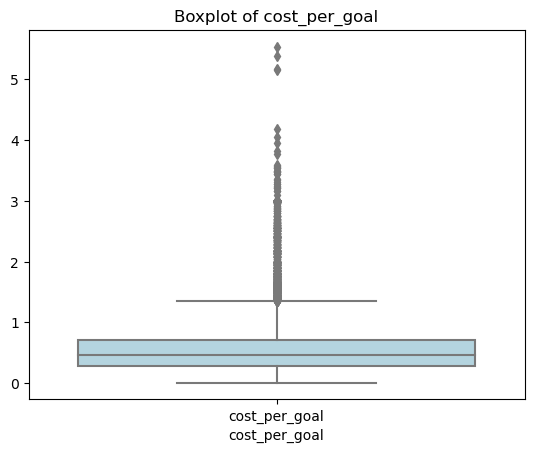

In [25]:
data = df_clicks[['cost_per_goal']]

sns.boxplot(data=data, color="lightblue")
plt.title('Boxplot of cost_per_goal')
plt.xlabel('cost_per_goal')
plt.show()

In [26]:
column_data = df_clicks['cost_per_goal']
z_scores = zscore(column_data)
threshold = 3
outliers = np.abs(z_scores) > threshold
print(column_data[outliers])

3836     2.17
3847     3.00
3850     2.17
3861     2.38
3863     2.55
         ... 
21579    3.00
21629    2.25
21659    3.00
21683    2.86
21701    2.39
Name: cost_per_goal, Length: 463, dtype: float64


In [27]:
number_of_outliers = column_data[outliers].count()
number_of_outliers

463

<Axes: xlabel='cost_per_goal', ylabel='Count'>

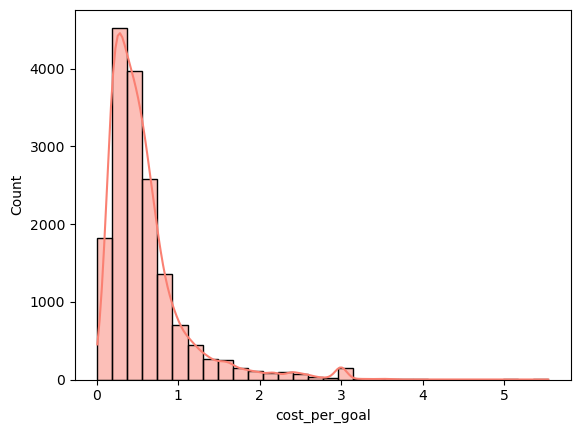

In [28]:
sns.histplot(df_clicks['cost_per_goal'], kde=True, bins=30, color="salmon")

In [29]:
df_clicks['advertising_platform_id'].value_counts()

advertising_platform_id
bing        9061
adwords     7326
facebook     249
Name: count, dtype: int64

In [30]:
df_clicks[df_clicks['advertising_platform_id'] == 'bing'].describe()

,max_goals,cost_per_goal,input_amount,start_year
count,9061.000000,9061.000000,9061.000000,9061.000000
mean,216.481073,0.584944,79.358117,2021.440901
std,264.666734,0.500408,61.791271,1.150084
min,0.000000,0.020000,0.000000,2017.000000
25%,85.000000,0.280000,54.750000,2021.000000
50%,148.000000,0.460000,63.700000,2021.000000
75%,250.000000,0.690000,95.550000,2022.000000
max,5673.000000,5.170000,1200.000000,2024.000000


In [31]:
df_clicks[df_clicks['advertising_platform_id'] == 'adwords'].describe()

,max_goals,cost_per_goal,input_amount,start_year
count,7326.000000,7326.000000,7326.000000,7326.000000
mean,223.244608,0.611790,82.921775,2021.632815
std,348.591019,0.517355,65.801230,1.172976
min,0.000000,0.010000,0.000000,2017.000000
25%,84.000000,0.290000,60.142500,2021.000000
50%,147.000000,0.470000,63.700000,2021.000000
75%,252.000000,0.730000,95.550000,2023.000000
max,11752.000000,5.540000,1200.000000,2024.000000


In [32]:
df_clicks[df_clicks['advertising_platform_id'] == 'facebook'].describe()

,max_goals,cost_per_goal,input_amount,start_year
count,249.000000,249.000000,249.000000,249.000000
mean,258.967871,0.572048,87.785261,2021.562249
std,343.300781,0.377495,58.386612,0.831063
min,21.000000,0.040000,25.460000,2020.000000
25%,93.000000,0.290000,55.000000,2021.000000
50%,146.000000,0.580000,75.000000,2021.000000
75%,289.000000,0.730000,99.550000,2022.000000
max,3100.000000,3.000000,500.500000,2024.000000


In [33]:
def count_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (data < lower_bound) | (data > upper_bound)
    return outliers.sum()

outliers_count = df_clicks.groupby('advertising_platform_id')['cost_per_goal'].apply(count_outliers)

outliers_count

advertising_platform_id
adwords     529
bing        635
facebook      6
Name: cost_per_goal, dtype: int64

In [71]:
df_clicks_filtered

,vertical,advertiser_country,cost_per_goal,advertising_platform_id,start_year
110,Agriculture,BE,0.19,bing,2020
141,Cars & Motorbikes,BE,0.22,bing,2020
220,Fashion & Clothing,BE,0.14,bing,2020
252,Home Improvement & Maintenance,BE,0.15,bing,2020
253,Interior Design & Furniture,BE,0.15,bing,2020
...,...,...,...,...,...
22102,Health,PT,0.20,bing,2021
22104,Electronics,PT,0.20,adwords,2019
22108,Industrial,PT,0.19,adwords,2019
22109,Home Improvement & Maintenance,PT,0.18,bing,2023


## Machine Learning

1. Prepare data

In [34]:
columns_to_drop = ['schedule_start', 'campaign_id', 'schedule_end', 'partner_name', 'internal_state_id', 'goal_id', 'state_id', 'input_amount', 'max_goals']
df_clicks_filtered = df_clicks.drop(columns=columns_to_drop)

In [35]:
vertical_counts = df_clicks_filtered['vertical'].value_counts()
verticals_to_keep = vertical_counts[vertical_counts >= 100].index
df_clicks_filtered = df_clicks_filtered[df_clicks_filtered['vertical'].isin(verticals_to_keep)]

In [36]:
df_clicks_filtered['vertical'].value_counts().head(30)

vertical
Home Improvement & Maintenance    3514
Others                            1769
Health                            1679
Industrial                        1495
Cars & Motorbikes                  826
Business                           775
Electronics                        426
Food & Drinks                      420
Transport & Logistics              418
Legal & Law                        367
Funeral Services                   327
Interior Design & Furniture        313
Beauty                             309
Restaurant                         309
Environment                        283
Animals & Pets                     248
School                             233
Accommodation & Hotels             231
Real Estate                        229
Fashion & Clothing                 226
Agriculture                        223
Security                           177
Pharmacy                           144
Flowers & Plants                   107
Accounting                         101
Name: count, dty

In [69]:
df_encoded_3_countries

,cost_per_goal,start_year,vertical_Accommodation & Hotels,vertical_Accounting,vertical_Agriculture,vertical_Animals & Pets,vertical_Beauty,vertical_Business,vertical_Cars & Motorbikes,vertical_Electronics,...,vertical_School,vertical_Security,vertical_Transport & Logistics,advertiser_country_AG,advertiser_country_BE,advertiser_country_ES,advertiser_country_PT,advertising_platform_id_adwords,advertising_platform_id_bing,advertising_platform_id_facebook
110,0.19,2020,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
141,0.22,2020,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
220,0.14,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
252,0.15,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
253,0.15,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22102,0.20,2021,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
22104,0.20,2019,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
22108,0.19,2019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
22109,0.18,2023,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [38]:
df_PT = df_clicks_filtered[df_clicks_filtered['advertiser_country'] == 'PT']
df_BE = df_clicks_filtered[df_clicks_filtered['advertiser_country'] == 'BE']
df_ES = df_clicks_filtered[df_clicks_filtered['advertiser_country'] == 'ES']

In [39]:
df_PT = df_PT.drop(columns=['advertiser_country'])
df_BE = df_BE.drop(columns=['advertiser_country'])
df_ES = df_ES.drop(columns=['advertiser_country'])

In [40]:
df_PT = df_PT.drop(columns=['start_year'])
df_BE = df_BE.drop(columns=['start_year'])
df_ES = df_ES.drop(columns=['start_year'])

In [41]:
df_encoded = pd.get_dummies(df_clicks_filtered)
df_encoded_PT = pd.get_dummies(df_PT)
df_encoded_BE = pd.get_dummies(df_BE)
df_encoded_ES = pd.get_dummies(df_ES)

In [42]:
df_encoded = df_encoded.replace({False: 0, True: 1})
df_encoded_PT = df_encoded_PT.replace({False: 0, True: 1})
df_encoded_ES = df_encoded_ES.replace({False: 0, True: 1})
df_encoded_BE = df_encoded_BE.replace({False: 0, True: 1})

In [43]:
df_encoded_no_year = df_encoded.drop(columns=['start_year'])

In [44]:
columns_to_drop = ['advertiser_country_BS', 'advertiser_country_DE', 
                   'advertiser_country_GB', 'advertiser_country_LU',
                   'advertiser_country_NL', 'advertiser_country_US']

df_encoded_3_countries = df_encoded.drop(columns=columns_to_drop)

In [45]:
countries_to_drop = ['LU', 'NL', 'US', 'BS', 'AG', 'DE', 'GB']

df_clicks_filtered_3_countries = df_clicks_filtered[~df_clicks_filtered['advertiser_country'].isin(countries_to_drop)]

In [46]:
from scipy.stats import zscore

z_scores = zscore(df_encoded['cost_per_goal'])

threshold = 3

outliers_mask = (np.abs(z_scores) > threshold)

df_encoded_cleaned = df_encoded[~outliers_mask]

print("Original shape:", df_encoded.shape)
print("Shape after removing outliers:", df_encoded_cleaned.shape)

Original shape: (15149, 40)
Shape after removing outliers: (14731, 40)


In [47]:
df_encoded_ES_GA = df_encoded_ES[df_encoded_ES['advertising_platform_id_bing'] != 1]
df_encoded_ES_GA = df_encoded_ES_GA.drop(columns=["advertising_platform_id_bing", "advertising_platform_id_adwords"])

In [48]:
df_encoded_PT_GA = df_encoded_PT[df_encoded_PT['advertising_platform_id_bing'] != 1]
df_encoded_PT_GA = df_encoded_PT_GA.drop(columns=["advertising_platform_id_bing", "advertising_platform_id_adwords"])

In [49]:
df_encoded_BE_GA = df_encoded_BE[(df_encoded_BE['advertising_platform_id_bing'] != 1) & (df_encoded_BE['advertising_platform_id_facebook'] != 1)]
df_encoded_BE_GA = df_encoded_BE_GA.drop(columns=["advertising_platform_id_bing", "advertising_platform_id_adwords", "advertising_platform_id_facebook"])

KNN

In [50]:
df_encoded

,cost_per_goal,start_year,vertical_Accommodation & Hotels,vertical_Accounting,vertical_Agriculture,vertical_Animals & Pets,vertical_Beauty,vertical_Business,vertical_Cars & Motorbikes,vertical_Electronics,...,advertiser_country_DE,advertiser_country_ES,advertiser_country_GB,advertiser_country_LU,advertiser_country_NL,advertiser_country_PT,advertiser_country_US,advertising_platform_id_adwords,advertising_platform_id_bing,advertising_platform_id_facebook
110,0.19,2020,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
141,0.22,2020,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
220,0.14,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
252,0.15,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
253,0.15,2020,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22102,0.20,2021,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
22104,0.20,2019,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
22108,0.19,2019,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
22109,0.18,2023,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [51]:
features = df_encoded_cleaned.drop(columns = ["cost_per_goal"])
target = df_encoded_cleaned["cost_per_goal"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=0)

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

scalers = {
    "MinMaxScaler": MinMaxScaler(),
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler(),
    "MaxAbsScaler": MaxAbsScaler(),
    "QuantileTransformer": QuantileTransformer(),
    "PowerTransformer": PowerTransformer()
}

for scaler_name, scaler in scalers.items():
    X_train_norm = scaler.fit_transform(X_train)
    X_test_norm = scaler.transform(X_test)
    
    knn = KNeighborsRegressor(n_neighbors=10)
    knn.fit(X_train_norm, y_train)
    
    y_pred = knn.predict(X_test_norm)
    
    r222_score = knn.score(X_test_norm, y_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    
    mse = mean_squared_error(y_test, y_pred)
    
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f"The R2 score of the model with {scaler_name} scaler is: {r222_score:.2f}")
    print(f"RMSE: {rmse:.2f}, MSE: {mse:.2f}, MAE: {mae:.2f}\n")

The R2 score of the model with MinMaxScaler scaler is: 0.11
RMSE: 0.34, MSE: 0.11, MAE: 0.24

The R2 score of the model with StandardScaler scaler is: 0.11
RMSE: 0.34, MSE: 0.11, MAE: 0.24

The R2 score of the model with RobustScaler scaler is: 0.11
RMSE: 0.34, MSE: 0.11, MAE: 0.24

The R2 score of the model with MaxAbsScaler scaler is: 0.11
RMSE: 0.34, MSE: 0.11, MAE: 0.24

The R2 score of the model with QuantileTransformer scaler is: 0.11
RMSE: 0.34, MSE: 0.11, MAE: 0.24

The R2 score of the model with PowerTransformer scaler is: 0.00
RMSE: 0.36, MSE: 0.13, MAE: 0.27



In [53]:
knn = KNeighborsRegressor(n_neighbors=10)
knn.fit(X_train, y_train)

r22_score = knn.score(X_test, y_test)

print(f"The R2 score of the model without scaler is: {r22_score:.2f}")

The R2 score of the model without scaler is: 0.15


In [54]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
print("Linear Regression MSE:", lr_mse)

# Decision Tree
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
dt_mse = mean_squared_error(y_test, dt_pred)
print("Decision Tree MSE:", dt_mse)

# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
print("Random Forest MSE:", rf_mse)

# Gradient Boosting Machines (GBM)
gbm = GradientBoostingRegressor()
gbm.fit(X_train, y_train)
gbm_pred = gbm.predict(X_test)
gbm_mse = mean_squared_error(y_test, gbm_pred)
print("GBM MSE:", gbm_mse)

Linear Regression MSE: 0.10940395308888297
Decision Tree MSE: 0.11058978091706892
Random Forest MSE: 0.1086859698536743
GBM MSE: 0.10435308712616038


In [55]:
param_grid = {
    'fit_intercept': [True, False]
}

lr = LinearRegression()

grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grid_search.fit(X_train, y_train)

best_lr = grid_search.best_estimator_

best_lr_pred = best_lr.predict(X_test)

best_lr_mse = mean_squared_error(y_test, best_lr_pred)
print("Best Linear Regression MSE:", best_lr_mse)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Linear Regression MSE: 0.4008401627086488
Best Hyperparameters: {'fit_intercept': False}


In [56]:
scalers = [MinMaxScaler(), StandardScaler(), RobustScaler(), MaxAbsScaler(), QuantileTransformer()]

models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

X = df_encoded_3_countries.drop(columns=["cost_per_goal"])
y = df_encoded_3_countries["cost_per_goal"]

for scaler in scalers:
    scaled_y = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

    X_train, X_test, y_train, y_test = train_test_split(X, scaled_y, test_size=0.15, random_state=42)

    print(f"Scaler: {scaler.__class__.__name__}")
    for name, model in models.items():
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        y_pred_original_scale = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)

        print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    print("-----------------------------")

Scaler: MinMaxScaler
Linear Regression - MSE: 0.0069, MAE: 0.0556, RMSE: 0.0829, R2: 0.1312
Decision Tree - MSE: 0.0070, MAE: 0.0545, RMSE: 0.0835, R2: 0.1169
Random Forest - MSE: 0.0069, MAE: 0.0542, RMSE: 0.0831, R2: 0.1260
Gradient Boosting - MSE: 0.0067, MAE: 0.0535, RMSE: 0.0816, R2: 0.1563
-----------------------------
Scaler: StandardScaler
Linear Regression - MSE: 0.7840, MAE: 0.5944, RMSE: 0.8854, R2: 0.1312
Decision Tree - MSE: 0.7920, MAE: 0.5807, RMSE: 0.8899, R2: 0.1222
Random Forest - MSE: 0.7892, MAE: 0.5803, RMSE: 0.8883, R2: 0.1254
Gradient Boosting - MSE: 0.7611, MAE: 0.5713, RMSE: 0.8724, R2: 0.1565
-----------------------------
Scaler: RobustScaler
Linear Regression - MSE: 1.1264, MAE: 0.7125, RMSE: 1.0613, R2: 0.1312
Decision Tree - MSE: 1.1386, MAE: 0.6962, RMSE: 1.0671, R2: 0.1217
Random Forest - MSE: 1.1322, MAE: 0.6946, RMSE: 1.0641, R2: 0.1267
Gradient Boosting - MSE: 1.0934, MAE: 0.6848, RMSE: 1.0457, R2: 0.1566
-----------------------------
Scaler: MaxAbsSca

In [57]:
#param_grid = {
#    'n_estimators': [50, 100, 200],
#    'learning_rate': [0.01, 0.1, 0.5],
#    'max_depth': [3, 5, 7]
#}

#gb_regressor = GradientBoostingRegressor()

#grid_search = GridSearchCV(gb_regressor, param_grid, cv=5, scoring='r2')

#grid_search.fit(X_train, y_train)

#best_params = grid_search.best_params_
#best_score = grid_search.best_score_

#print("Best Parameters:", best_params)
#print("Best Score:", best_score)

In [58]:
best_gb_regressor = GradientBoostingRegressor(learning_rate=0.5, max_depth=5, n_estimators=50)

best_gb_regressor.fit(X_train, y_train)

y_pred = best_gb_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2_metric = r2_score(y_test, y_pred)

print("Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2_metric:.4f}")

Evaluation Metrics:
MSE: 0.0604
MAE: 0.2015
RMSE: 0.2457
R2 Score: 0.2572


In [59]:
#model_file_path = "best_gb_regressor_model.pkl"
#joblib.dump(best_gb_regressor, model_file_path)

['best_gb_regressor_model.pkl']

In [60]:
loaded_model = joblib.load('best_gb_regressor_model.pkl')

In [61]:
vertical_options = df_clicks_filtered_3_countries['vertical'].unique()
country_options = df_clicks_filtered_3_countries['advertiser_country'].unique()
platform_options = df_clicks_filtered_3_countries['advertising_platform_id'].unique()

print("Please enter the following information:")
vertical = input(f"Vertical ({', '.join(vertical_options)}): ")
country = input(f"Advertiser Country ({', '.join(country_options)}): ")
platform = input(f"Advertising Platform ID ({', '.join(platform_options)}): ")

user_data = pd.DataFrame({
    'vertical': [vertical],
    'advertiser_country': [country],
    'advertising_platform_id': [platform]
})

user_data_encoded = pd.DataFrame(columns=df_encoded_3_countries.columns)
user_data_encoded.loc[0] = 0
user_data_encoded['vertical_' + vertical] = 1
user_data_encoded['advertiser_country_' + country] = 1
user_data_encoded['advertising_platform_id_' + platform] = 1

user_data_encoded = user_data_encoded.drop(columns=['cost_per_goal'], errors='ignore')

predictions = loaded_model.predict(user_data_encoded)

print("Predicted cost_per_goal:", predictions[0])

Please enter the following information:
Vertical (Agriculture, Cars & Motorbikes, Fashion & Clothing, Home Improvement & Maintenance, Interior Design & Furniture, Business, Electronics, Food & Drinks, Pharmacy, Transport & Logistics, Health, Industrial, Animals & Pets, Environment, Real Estate, Others, Beauty, Legal & Law, Accommodation & Hotels, Flowers & Plants, Funeral Services, Restaurant, School, Security, Accounting): Agriculture
Advertiser Country (BE, PT, ES): BE
Advertising Platform ID (bing, adwords, facebook): bing
Predicted cost_per_goal: 0.41461722175072635


In [62]:
#csv_file_path = "df_clicks_filtered.csv"
#df_clicks_filtered.to_csv(csv_file_path, index=False)

In [63]:
#csv_file_path = "data_for_model.csv"
#df_encoded_3_countries.to_csv(csv_file_path, index=False)

In [65]:
#csv_file_path = "df_clicks_filtered_3_countries.csv"
#df_clicks_filtered_3_countries.to_csv(csv_file_path, index=False)

### Feature Selection